In [1]:
import os
import itertools
import glob
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tqdm as tqdm
import matplotlib as mpl
import matplotlib.ticker
import matplotlib.pyplot as plt
import zipfile
import PIL.Image

sns.set(font_scale=0.9, style='whitegrid', font='CMU Sans Serif')
pal = sns.color_palette(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
sns.set_palette(pal)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,2)
mpl.rcParams['figure.dpi'] = 100

In [2]:
IMAGE_LOG = "../pkg/model/image_log_with_alt.csv"
IMAGES = "../pkg/model/images"

BAND_INDICES = {
    "B01": 0,
    "B02": 1,
    "B03": 2,
    "B04": 3,
    "B05": 4,
    "B06": 5,
    "B07": 6,
    "B08": 7,
    "B8A": 8,
    "B09": 9,
    "B11": 10,
    "B12": 11,
    "CLD": 12,
}

In [70]:
# read the image log to find out what images exist
image_ids = []
sunlights = []
sunlit = False
with open(IMAGE_LOG, 'r') as f:
    for line in f:
        if line.startswith("t_ms"):
            continue
        t_ms, lat, lon, alt, is_sunlit = line.strip().split(',')
        if not (is_sunlit == "1") == sunlit:
            sunlit = (is_sunlit == "1")
            sunlights.append((sunlit, t_ms))

        image_ids.append((t_ms, (is_sunlit == "1")))

In [71]:
# the CLD band is our baseline
def cld_cloud_percentage(image):
    # don't ask why, but there are some images where a CLD pixel is above 100
    return np.sum(np.clip(image, 0, 100)) / 100 / (image.shape[0] * image.shape[1])

In [72]:
def read_image(image_path):
    # basically a zip file of a bunch of tiffs
    # ..._B01.tiff, ..._B02.tiff, etc.
    with zipfile.ZipFile(image_path) as zf:
        # print(f"Reading {os.path.basename(image_path)}")
        with zf.open(f"{os.path.basename(image_path)[:-4]}_CLD.tiff") as f:
            return np.array(PIL.Image.open(f))

images = [os.path.join(IMAGES, f"{i}.zip") for i in image_ids]

clouds = [(i, sunlit, cld_cloud_percentage(read_image(os.path.join(IMAGES, f"{i}.zip")))) for i, sunlit in tqdm.tqdm(image_ids)]

100%|██████████| 54000/54000 [00:38<00:00, 1406.23it/s]


In [73]:
df = pd.DataFrame(clouds, columns=["image_id", "sunlit", "cloud_percentage"])
df.to_csv("moreclouds.csv")
df.head()

,image_id,sunlit,cloud_percentage
0,0,True,1.000000
1,400,True,1.000000
2,800,True,0.999949
3,1200,True,0.999941
4,1600,True,1.000000


In [ ]:
# smooth the data
# 5s rolling mean
# first create datetime index on image_id
df = pd.read_csv("moreclouds.csv")
df_smooth = df.copy()
df_smooth['image_id'] = df_smooth['image_id'].astype(int)
df_smooth['timestamp'] = pd.to_datetime(df_smooth['image_id'], unit='ms')
df_smooth = df_smooth.set_index('timestamp')
df_smooth = df_smooth.resample('1min').mean()

(False, '1081200') (True, '3957600')
(False, '6597600') (True, '9808800')
(False, '12133600') (True, '15492400')
(False, '17456400') (True, '20951200')


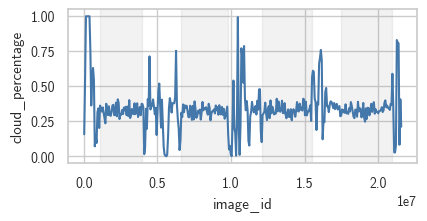

In [75]:
# plot the cloud percentage, then add grey boxes for the non-sunlit periods
fig, ax = plt.subplots()

sns.lineplot(data=df_smooth, x="image_id", y="cloud_percentage", ax=ax)

# add grey boxes for non-sunlit periods
# get first non-sunlit period
first_darkness = 0
for i in range(len(sunlights)):
    if not sunlights[i][0]:
        first_darkness = i
        break

for i in range(first_darkness, len(sunlights), 2):
    print(sunlights[i], sunlights[i+1])
    ax.axvspan(int(sunlights[i][1]), int(sunlights[i+1][1]), color='grey', alpha=0.1)

In [76]:
# get the length of the sunlit and not sunlit periods
lengths = [(int(sunlights[i+1][1]) - int(sunlights[i][1]), "sun" if sunlights[i][0] else "dark") for i in range(0, len(sunlights)-1)]

for l in lengths:
    print(l)

(1081200, 'sun')
(2876400, 'dark')
(2640000, 'sun')
(3211200, 'dark')
(2324800, 'sun')
(3358800, 'dark')
(1964000, 'sun')
(3494800, 'dark')


In [77]:
# skip the first two, then get the ratio
R_sunlit = sum([l[0] for l in lengths[2:] if l[1] == "sun"]) / sum([l[0] for l in lengths[2:]])
print(f"Sunlit ratio: {R_sunlit:.4f}")

Sunlit ratio: 0.4077


In [78]:
# cloud ratio (only for sunlit images)
sunlit_clouds = df[df['sunlit']]
sunlit_clouds["too_cloudy"] = sunlit_clouds["cloud_percentage"] > 0.3
R_cloudy = sunlit_clouds["too_cloudy"].sum() / len(sunlit_clouds)
print(f"Cloud ratio: {R_cloudy:.4f}")

Cloud ratio: 0.4435


/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_59546/2853510774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sunlit_clouds["too_cloudy"] = sunlit_clouds["cloud_percentage"] > 0.3


In [79]:
sunlit_clouds["cloud_percentage"].mean()

0.3636029840732726

In [80]:
R_filter = 1 - R_sunlit * (1-R_cloudy)
print(f"Filter ratio: {R_filter:.4f}")

Filter ratio: 0.7731
